In [206]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

# MLE 

In [207]:
def define_dataset(a, b, N, k, sigma):
    X = np.linspace(a, b, N)

    Phi = vander(X, k)
    
    theta_true = np.ones((k, )) 
    
    Y = Phi @ theta_true
    gaussian_noise = np.random.normal(0, 1, Y.shape)
    Y = Y + sigma * gaussian_noise #Noisy Y

    D = (X, Y)

    return D

#Generalized Vandermonde Matrix
def vander(X, k):
    N = len(X)

    phi = np.zeros((N, k))

    for j in range(k):
        phi[:,j] = X**j 

    return phi

In [208]:
def split_data(X, Y, percentage_train):

    N = len(X)
    Ntrain = int(percentage_train*N/100)

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

In [209]:
#Degree of polynomial
k_chosen = (int) (input("Choose the degree of the polynomial: ")) 

#Input dataset
a = (int) (input("Choose an interval [a, b] --a: "))
b = (int) (input("Choose an interval [a, b] --b: ")) 

sigma = (float) (input("Choose the variance of the noise: "))

N = 100 #number of datapoints

X, Y = define_dataset(a, b, N, k_chosen, sigma)
D = (X, Y)

D_train, D_test = split_data(D[0], D[1], 70)
X_train, Y_train = D_train
X_test, Y_test = D_test


Pretend not to know the correct value of k. The task is to try guess it and use it to approximate the true solution $theta_{true}$ by MLE and MAP.

In [210]:
def f_MLE(X, Y):
    return lambda theta: 0.5 * (np.linalg.norm((vander(X, len(theta)) @ theta) - Y))**2

def grad_f_MLE(X, Y):
    return lambda theta: vander(X, len(theta)).T @ ((vander(X, len(theta)) @ theta) - Y)

def f_MAP(X, Y, lamda):
    return lambda theta: 0.5 * (np.linalg.norm((vander(X, len(theta)) @ theta) - Y))**2 + (lamda/2 * (np.linalg.norm(theta))**2)
    
def grad_f_MAP(X, Y, lamda):
    return lambda theta: vander(X, len(theta)).T @ ((vander(X, len(theta)) @ theta) - Y) + 2*lamda*np.array(theta)

In [211]:
def GD(grad_f, x0, kmax=100, tolf=1e-6, tolx=1e-6, alpha=1e-3):
    k = 0
    dim_m, dim_n = (kmax+1, x0.shape[0])
    x = np.empty((dim_m, dim_n))

    x[k]=x0
    
    conditions = True

    while (conditions and k < kmax):
        k = k+1

        x[k] = x[k-1]-alpha*grad_f(x[k-1])

        cond1 = np.linalg.norm(grad_f(x[k])) > tolf * grad_f(x[k-1]).all()
        cond2 = np.linalg.norm(x[k] - x[k-1]) > tolx * np.linalg.norm(x[k-1]).all()
        conditions = cond1 and cond2
    
    x = x[:k+1]
    
    return x[-1]

def SGD(grad_l, w0, D, batch_size, n_epochs, lamda=0, alpha=1e-3):
    X, Y = D  
    N = X.shape[0]

    n_batch_per_epoch = N//batch_size
    tot_batch = n_batch_per_epoch * n_epochs
    
    w = np.array(w0)
    w_vector = np.zeros((tot_batch, len(w0)))
        
    for epoch in range(n_epochs):
        X_shuffle, Y_shuffle = shuffle_data(X, Y)
        
        for b in range (n_batch_per_epoch):  
            n = b*batch_size
            m = (b+1)*batch_size

            Mx = X_shuffle[n:m]
            My = Y_shuffle[n:m]

            if lamda==0:
                gradient=grad_l(Mx, My)
            else:
                gradient=grad_l(Mx, My, lamda)
            
            w=w-alpha*gradient(w)
            w_vector[epoch*n_batch_per_epoch + b, :] = w
    
    return w_vector[-1]

def shuffle_data(X, Y):
    N = X.shape[0]
    indexes = np.arange(N)
    np.random.shuffle(indexes)

    X_shuffle = X[indexes]
    Y_shuffle = Y[indexes]

    return X_shuffle, Y_shuffle

In [212]:
def MLE(D, k_trial, mod):
    X, Y = D
    Phi_trial = vander(X, k_trial)

    if mod[0]=='N':
        #Normal equation    
        A = Phi_trial.T @ Phi_trial
        b = Phi_trial.T @ Y
        try:
            L = scipy.linalg.cholesky(A, lower = True)
            y = scipy.linalg.solve_triangular(L, b, lower = True)
            theta_mle = scipy.linalg.solve_triangular(L.T, y)
        except:
            theta_mle = np.linalg.solve(Phi_trial.T @ Phi_trial, Phi_trial.T @ Y)

    elif mod[0]=='G':
        #Gradient Descent
        theta_mle = GD(grad_f_MLE(X, Y), np.zeros((k_trial,)))

    else:
        #Stochastic Gradient Descent
        theta_mle = SGD(grad_f_MLE, np.zeros((k_trial, )), D, batch_size = 5, n_epochs = 10)

    return theta_mle

In [213]:
theta_mle_normal = MLE(D, k_chosen, 'Normal equation')
theta_mle_gd = MLE(D, k_chosen, 'GD')
theta_mle_sgd = MLE(D, k_chosen, 'SGD')

print("Theta, MLE - Normal equation: ", theta_mle_normal)
print("Theta, MLE - GD: ", theta_mle_gd)
print("Theta, MLE - SGD: ", theta_mle_sgd)

Theta, MLE - Normal equation:  [0.98171263 1.14624711 0.86958274 0.96888406]
Theta, MLE - GD:  [1.06255607 1.06258762 0.92149537 0.80063846]
Theta, MLE - SGD:  [1.05073984 0.68853411 0.52470793 0.42730751]


In [214]:
def polynomial_regression(X, k, theta):
    Phi = vander(X, k)
    return Phi @ theta

def error(D, k, theta):
    X, Y = D
    N = len(Y)

    f_theta = polynomial_regression(X, k, theta)

    return ((np.linalg.norm(f_theta - Y))**2) / N

For different values of K, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model $f_{theta_{MLE}}(x)$.

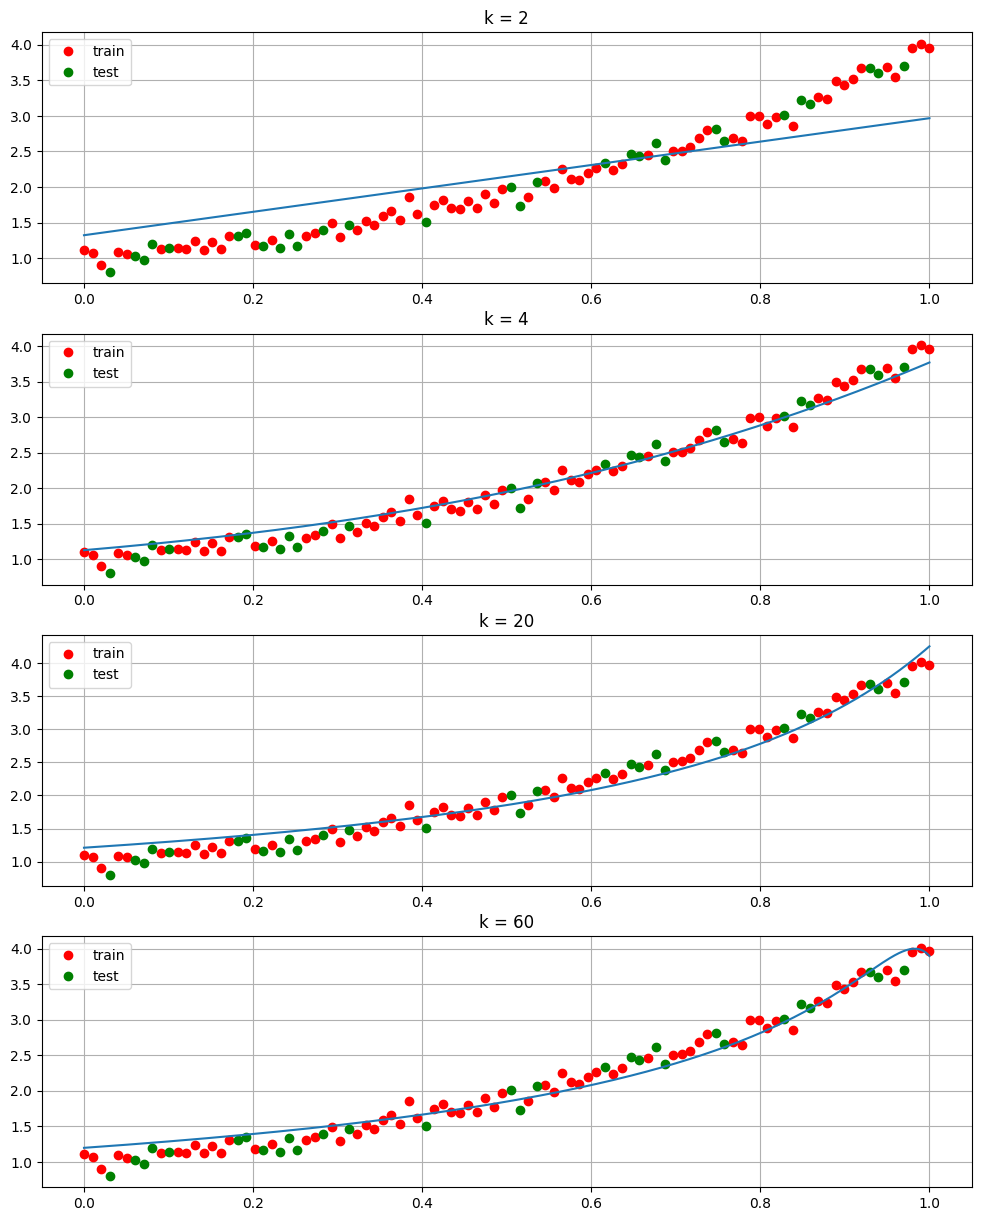

In [215]:
k_vector = [2, 4, 20, 60]
theta_mle_vector = []

for k in k_vector:
    theta_mle = MLE(D_train, k, "GD")
    theta_mle_vector.append(theta_mle)

fig, ax = plt.subplots(len(k_vector), figsize=(12, 15))

for i in range(len(k_vector)):

    theta = theta_mle_vector[i]
    k = k_vector[i]
    
    XX = np.linspace(a, b, 1000)    
    YY = polynomial_regression(XX, k, theta)
    
    ax[i].set_title(f'k = {k}')
    ax[i].plot(X_train, Y_train, 'ro')
    ax[i].plot(X_test, Y_test, 'go')
    ax[i].legend(['train', 'test'])
    ax[i].plot(XX, YY)
    ax[i].grid()

plt.show()

For increasing values of K cmpute the training and test error. Plot the two errors with respect to K.

[]

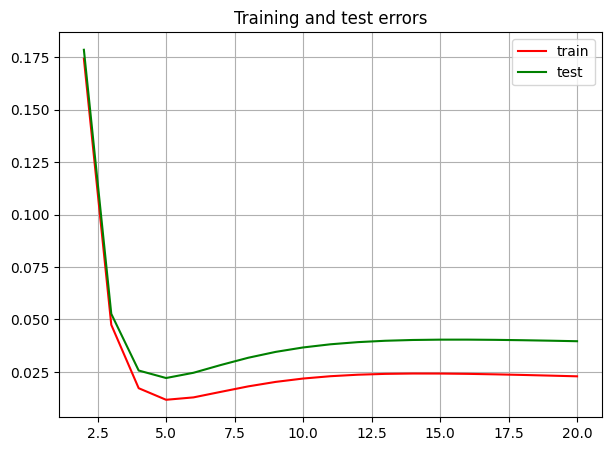

In [216]:
k_vector = np.arange(2, 21)

theta_vector = []
errors_train = []
errors_test = []

for k in k_vector:
    theta_mle = MLE(D_train, k, "GD")
    theta_vector.append(theta_mle)

    training_error = error(D_train, k, theta_mle)
    errors_train.append(training_error)
    
    test_error = error(D_test, k, theta_mle)
    errors_test.append(test_error)

plt.figure(figsize=(7,5))
plt.title("Training and test errors")
plt.plot(k_vector, errors_train, color='red')
plt.plot(k_vector, errors_test, color='green')
plt.legend(['train', 'test'])
plt.grid()
plt.plot()  

# MAP

Write a function that returns the MAP solution. Note that the loss function can be optimized by GD, SGD or Normal Equations.

In [217]:
def MAP(D, k_trial, lmbda, mod):
    X, Y = D

    Phi = vander(X, k_trial)

    if mod[0] == 'N':        
        #Normal equation
        A = (Phi.T @ Phi) + (lmbda * np.identity(k_trial))
        b = Phi.T @ Y

        try:
            L = scipy.linalg.cholesky(A, lower = True)
            y = scipy.linalg.solve_triangular(L, b, lower = True)
            theta_MAP = scipy.linalg.solve_triangular(L.T, y)
        except:
            theta_MAP = np.linalg.solve((Phi.T @ Phi) + (lmbda * np.identity(k_trial)), Phi.T@Y)

    elif mod[0] == 'G':
        #Gradient Descent
        theta_MAP = GD(grad_f_MAP(X, Y, lmbda), np.zeros((k_trial, )))
    
    else:
        #Stochastic Gradient Descent
        theta_MAP = SGD(grad_f_MAP, np.zeros((k_trial, )), D, 5, 10, lmbda)

    return theta_MAP

In [218]:
theta_map_normal = MAP(D, k_chosen, 1, 'Normal equation')
theta_map_gd = MAP(D, k_chosen, 1, 'GD')
theta_map_sgd = MAP(D, k_chosen, 1, 'SGD')

print("Theta, MAP, lambda = 1 - Normal equation: ", theta_map_normal)
print("Theta, MAP, lambda = 1 - GD: ", theta_map_gd)
print("Theta, MAP, lambda = 1 - SGD: ", theta_map_sgd)

Theta, MAP, lambda = 1 - Normal equation:  [0.99902566 1.08570032 0.96566516 0.85317634]
Theta, MAP, lambda = 1 - GD:  [1.06972382 1.03545407 0.8910705  0.77146094]
Theta, MAP, lambda = 1 - SGD:  [0.91067276 0.59374062 0.45132836 0.36691072]


For K lower, equal and greater than the correct degree of the test polynomial, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model $f_{theta_{MAP}}(x)$ with different values of lambda.

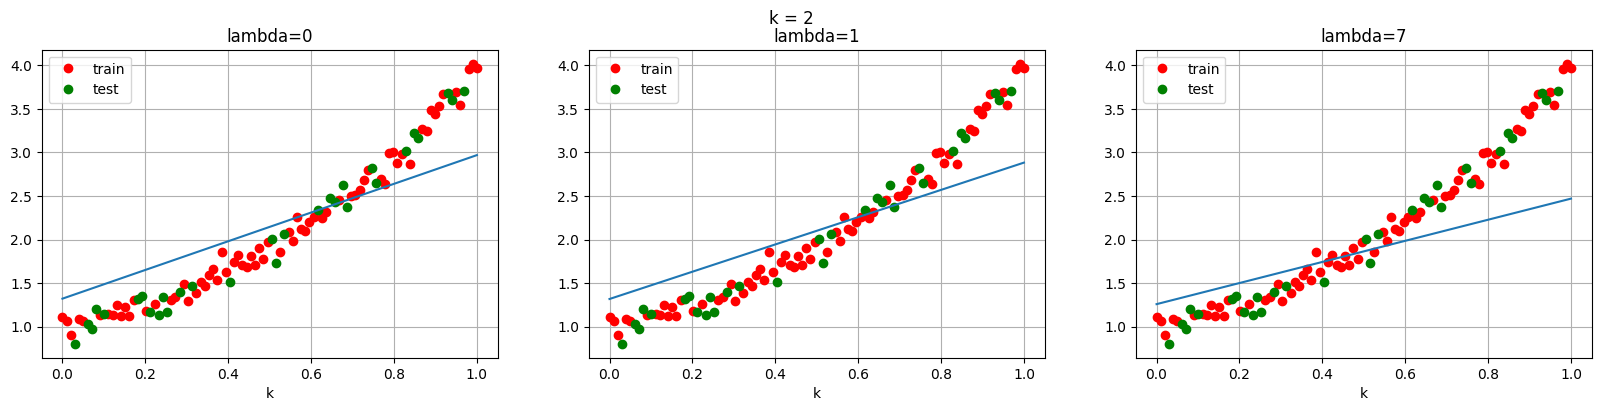

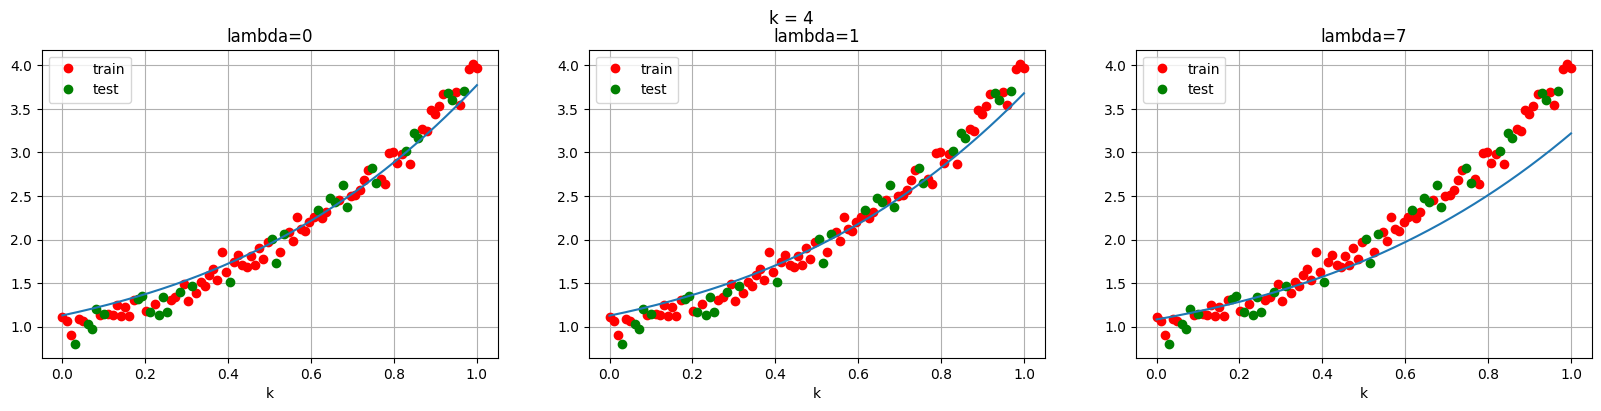

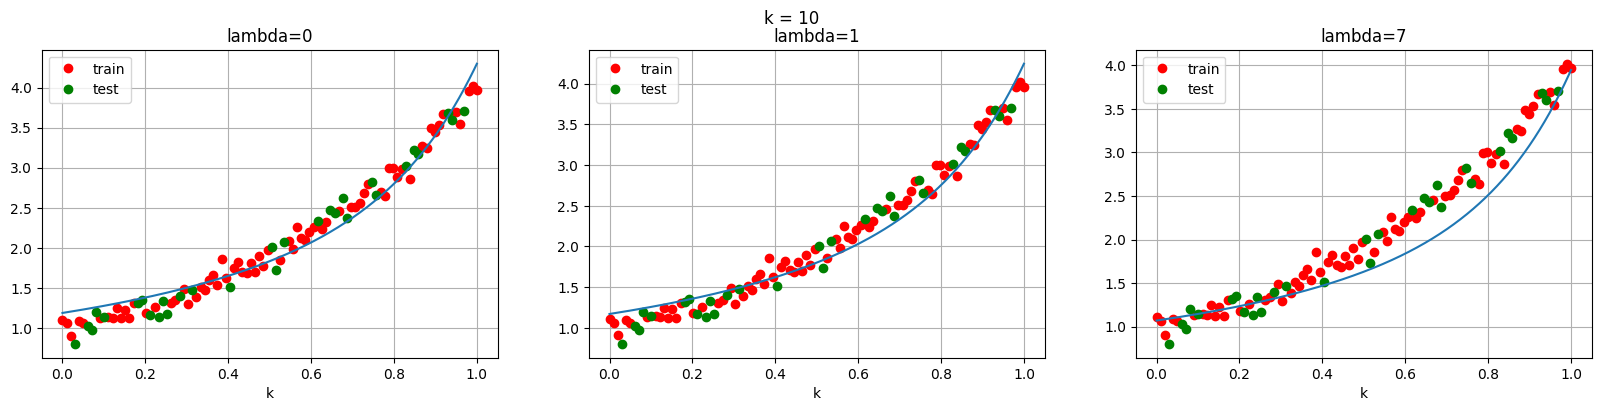

In [219]:
k_vector = [2, 4, 10]
l_vector = [0, 1, 7]

theta_tot_k = []

for k in k_vector:
    
    theta_tot_l = []

    for l in l_vector:
        theta_map = MAP(D_train, k, l, "GD")
        theta_tot_l.append(theta_map)

    theta_tot_k.append(theta_tot_l)

for i in range(len(k_vector)):
    k = k_vector[i]

    plt.figure(figsize=(20, 4))
    plt.suptitle(f'k = {k}')

    for j in range(len(theta_tot_k[i])):
        theta = theta_tot_k[i][j]
            
        plt.subplot(1, len(theta_tot_k[i]), j+1)
        plt.title(f"lambda={l_vector[j]}")
        plt.xlabel('k')
        
        XX = np.linspace(a, b, 1000)   
        YY = polynomial_regression(XX, k, theta)
        plt.plot(X_train, Y_train, 'ro')
        plt.plot(X_test, Y_test, 'go')
        plt.legend(['train', 'test'])
        plt.plot(XX, YY)
        plt.grid()

plt.show()

For increasing values of K cmpute the training and test error. Plot the two errors with respect to K.

[]

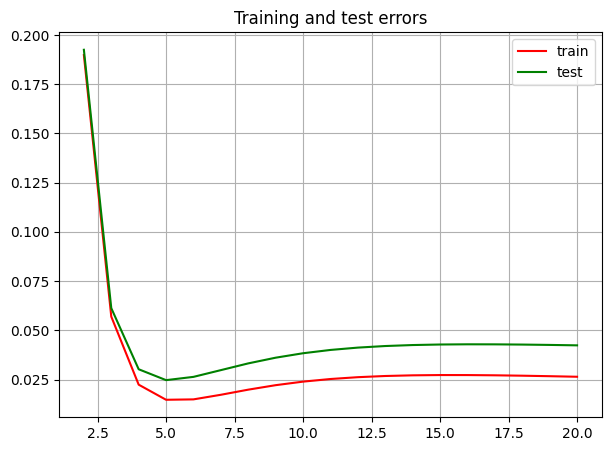

In [220]:
k_vector = np.arange(2, 21)

theta_vector = []
errors_train = []
errors_test = []

lmbda = 1

for k in k_vector:
    theta_map = MAP(D_train, k, lmbda, "GD")
    theta_vector.append(theta_map)

    training_error = error(D_train, k, theta_map)
    errors_train.append(training_error)
    
    test_error = error(D_test, k, theta_map)
    errors_test.append(test_error)

plt.figure(figsize=(7,5))
plt.title("Training and test errors")
plt.plot(k_vector, errors_train, color='red')
plt.plot(k_vector, errors_test, color='green')
plt.legend(['train', 'test'])
plt.grid()
plt.plot() 

# MLE and MAP

For K being way greater than the correct degree of the polynomial, compute the MLE and MAP solution. Compare the test error of the two, for different values of lambda (in the case of MAP).

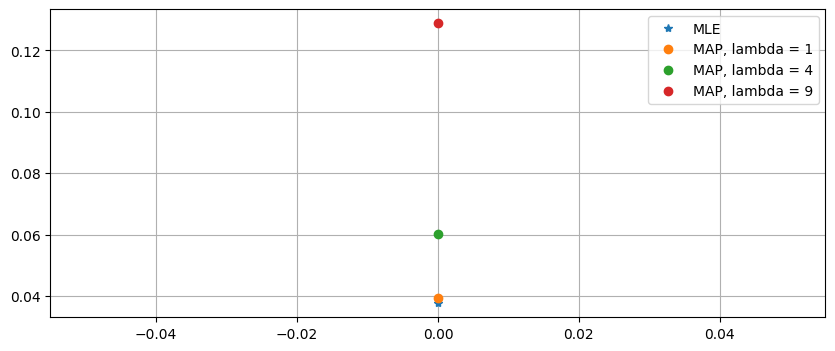

In [224]:
k_big = 70
l_vector = [1, 4, 9]

theta_mle = MLE(D_train, k_big, "GD")
thetas_map = [MAP(D_train, k_big, l, "GD") for l in l_vector]

mle_error = error(D_test, k_big, theta_mle)
map_errors = [error(D_test, k_big, theta_map) for theta_map in thetas_map]

legend_mle = ['MLE']
legend_map = ['MAP, lambda = ' + str(l) + '' for l in l_vector]
legend = legend_mle + legend_map

plt.figure(figsize=(10,4))
plt.plot(mle_error, '*')
for i in range(len(l_vector)):
    plt.plot(map_errors[i], 'o')
plt.legend(legend)
plt.grid()
plt.show()

For K greater than the true degree of the polynomial, define the relative error and compute it for MLE and MAP for
increasing values of K.

In [222]:
def err_theta(theta, k):
    theta_true = np.ones((k,))
    diff = len(theta) - k
    if(diff > 0):
        theta_true = np.concatenate(theta_true, np.zeros(diff,))
    return np.linalg.norm(theta - theta_true) / np.linalg.norm(theta_true)

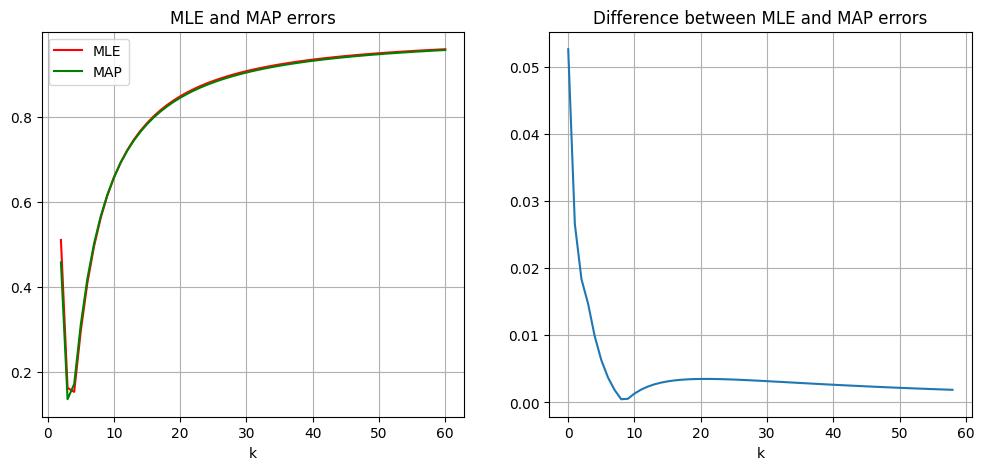

In [223]:
k_vector = np.arange(2, 61)
lmbda = 1

theta_mle_error_tot_k = np.asarray([err_theta(MLE(D_train, k, "GD"), k) for k in k_vector])
theta_map_error_tot_k = np.asarray([err_theta(MAP(D_train, k, lmbda, "GD"), k) for k in k_vector])
diff = np.linalg.norm(theta_mle_error_tot_k[:, np.newaxis] - theta_map_error_tot_k[:, np.newaxis], axis=1)

legend = ['MLE', 'MAP']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("MLE and MAP errors")
plt.plot(k_vector, theta_mle_error_tot_k, color='red')
plt.plot(k_vector, theta_map_error_tot_k, color='green')
plt.xlabel('k')
plt.legend(legend)
plt.grid()

plt.subplot(1, 2, 2)
plt.title("Difference between MLE and MAP errors")
plt.plot(diff)
plt.xlabel('k')
plt.grid()

plt.show()